In [12]:
import numpy as np
import h5py
import os 
import json
import scipy.io as spio
import matplotlib.pyplot as plt 

# This is a python implementation of 

# Jin et al. (2015), Adaptive reference updating for vibration-based
# structural health monitoring under varying environmental conditions,
# Computers & Structures.

In [2]:
##  SIMULATION OPTIONS 
# (1) Select Damage Scenario

# Four damage senarios are available as below:
# case0_lin: No damage occurs under linear dependency to temp.
# case1_lin: Damage occurs at #sample of 700  under linear dependency to temp
# case0_bi_lin: No damage occurs under non-linear dependency to temp.
# case1_bi_lin: Damage occurs at #sample of 700 under non-linear dependency to temp

## uncommnet senario that you want to run 

# fn='case0_lin'; # No damage // Quasi-Linear
# fn='case1_lin'; # Damage at #700 // Quasi-Linear
# fn='case0_bi_lin'; # No damage // Bi-linear 
fn= 'case1_bi_lin'; # Damage at #700 // Bi-linear 

In [3]:
## (2) Select Noise Level
# SNR 100dB: No noise
# SNR 60dB: Noise injected
# Smaller SNR indicates large noise
# noise_amp=0.00001; # SNR 100 dB
noise_amp=0.001; # SNR 60 dB

In [4]:
## (3) Define Size of Initial Training Sample
# Do not define the size above 700 for the damage scenarios (i.e., case1_*.mat)
n_init = 200;

In [5]:
## (4) Define file name for saving simulated data
fn_sv = ['DB_' + fn + '_' + str(noise_amp) + '.mat'] # Change filename as you wish

In [7]:
simul_data = spio.loadmat(os.path.join('DB_for_Scenario', fn+'.mat'))

In [14]:
t = simul_data['t']
Elem_temp = simul_data['Elem_temp']
Elem_damage = simul_data['Elem_damage']
D_point = simul_data['D_point']
D_Quan = simul_data['D_Quan']
Phi_Z1 = simul_data['Phi_Z1']
Phi_R1 = simul_data['Phi_R1']
Freq = simul_data['Freq']

<function matplotlib.pyplot.show>

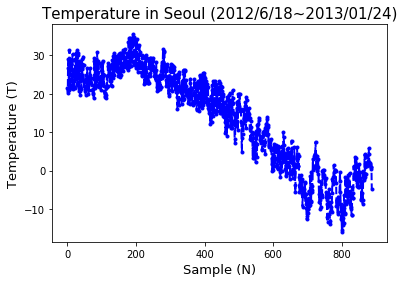

In [49]:
## Plot Hist. of Temp.
# Temperature history of Seoul was obtained from www.kma.go.kr
# Period for sampling: 2012/6/18~2013/01/24

%matplotlib inline
plt.plot(np.array(range(0, t.shape[1])), t[0], 'bo--', linewidth=2, markersize=3)
plt.title('Temperature in Seoul (2012/6/18~2013/01/24)', fontsize=15)
plt.xlabel('Sample (N)',fontsize=13)
plt.ylabel('Temperature (T)',fontsize=13)
plt.show